In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, PrecisionRecallDisplay, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/neilaxu/schulich_data_science/main/MBAN%206750%20HW/Employee_Attrition_Data_Set(1).csv')

In [3]:
df.head()

Employee ID  Age  Gender    Job Role Department  Monthly Income  \
0            1   50    Male          HR         IT           11547   
1            2   36    Male       Sales    Support            8643   
2            3   29    Male  Technician         HR           12418   
3            4   42    Male  Technician    Support           11441   
4            5   40  Female    Engineer      Sales            9178   

   Years at Company  Number of Promotions  Last Raise Percentage  \
0                12                     1              12.288783   
1                28                     4               3.496371   
2                12                     4               4.796945   
3                25                     1              10.310471   
4                25                     2               6.210127   

   Distance from Office  Job Satisfaction  Performance Rating Attrition  
0             41.307654                 9                   1        No  
1             44.733204                 8                   1       Yes  
2             18.646876                 1                   3        No  
3             15.790848                 8                   4        No  
4             41.239179                 6                   4        No

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Employee ID            10000 non-null  int64  
 1   Age                    10000 non-null  int64  
 2   Gender                 10000 non-null  object 
 3   Job Role               10000 non-null  object 
 4   Department             10000 non-null  object 
 5   Monthly Income         10000 non-null  int64  
 6   Years at Company       10000 non-null  int64  
 7   Number of Promotions   10000 non-null  int64  
 8   Last Raise Percentage  10000 non-null  float64
 9   Distance from Office   10000 non-null  float64
 10  Job Satisfaction       10000 non-null  int64  
 11  Performance Rating     10000 non-null  int64  
 12  Attrition              10000 non-null  object 
dtypes: float64(2), int64(7), object(4)
memory usage: 1015.8+ KB


In [5]:
df.describe()

Employee ID           Age  Monthly Income  Years at Company  \
count  10000.00000  10000.000000    10000.000000      10000.000000   
mean    5000.50000     40.561200     8948.750300         14.311100   
std     2886.89568     10.876483     3473.354793          8.742572   
min        1.00000     22.000000     3000.000000          0.000000   
25%     2500.75000     31.000000     5895.000000          7.000000   
50%     5000.50000     41.000000     8982.500000         14.000000   
75%     7500.25000     50.000000    11928.250000         22.000000   
max    10000.00000     59.000000    14999.000000         30.000000   

       Number of Promotions  Last Raise Percentage  Distance from Office  \
count          10000.000000           10000.000000          10000.000000   
mean               1.958300              10.022797             26.632481   
std                1.426171               5.823696             14.396393   
min                0.000000               0.000000              1.000000   
25%                1.000000               5.101189             14.509275   
50%                2.000000               9.990978             27.122930   
75%                3.000000              15.042273             39.148606   
max                5.000000              20.000000             50.000000   

       Job Satisfaction  Performance Rating  
count      10000.000000        10000.000000  
mean           5.407000            2.992900  
std            2.943504            1.410833  
min            1.000000            1.000000  
25%            3.000000            2.000000  
50%            5.000000            3.000000  
75%            8.000000            4.000000  
max           10.000000            5.000000

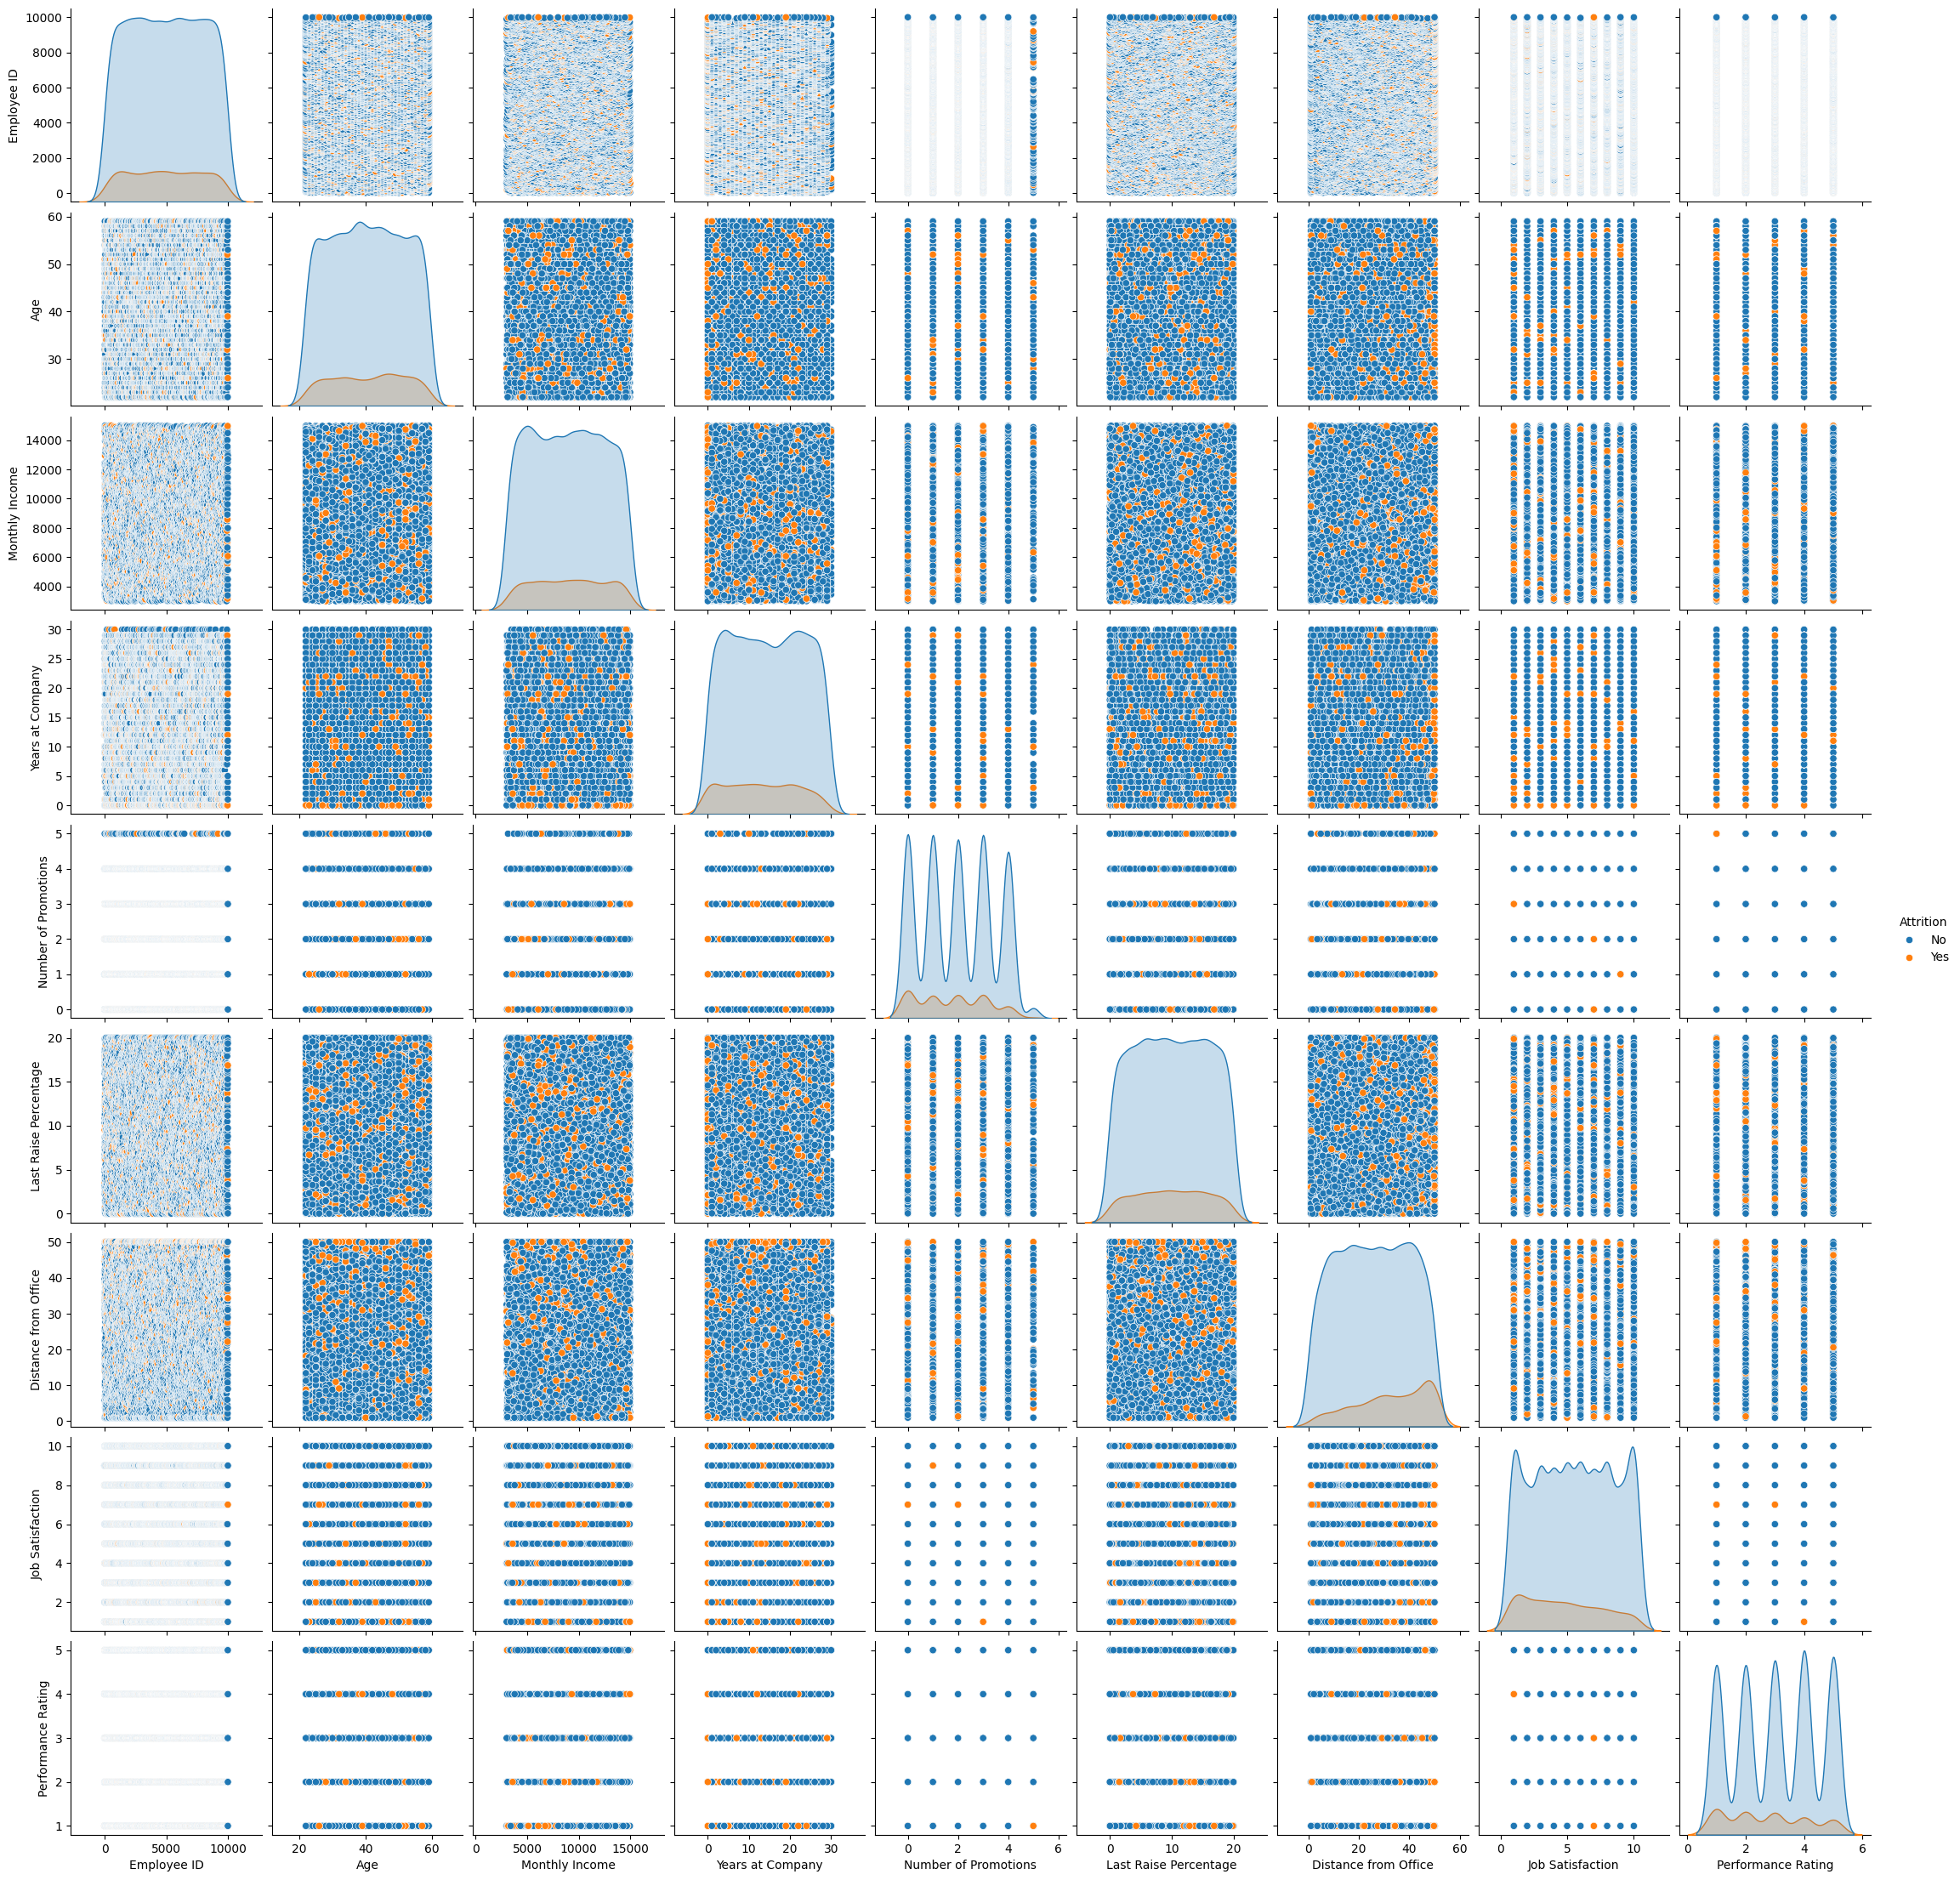

In [12]:
sns.pairplot(df, hue='Attrition')

In [6]:
from scipy.stats import chi2_contingency

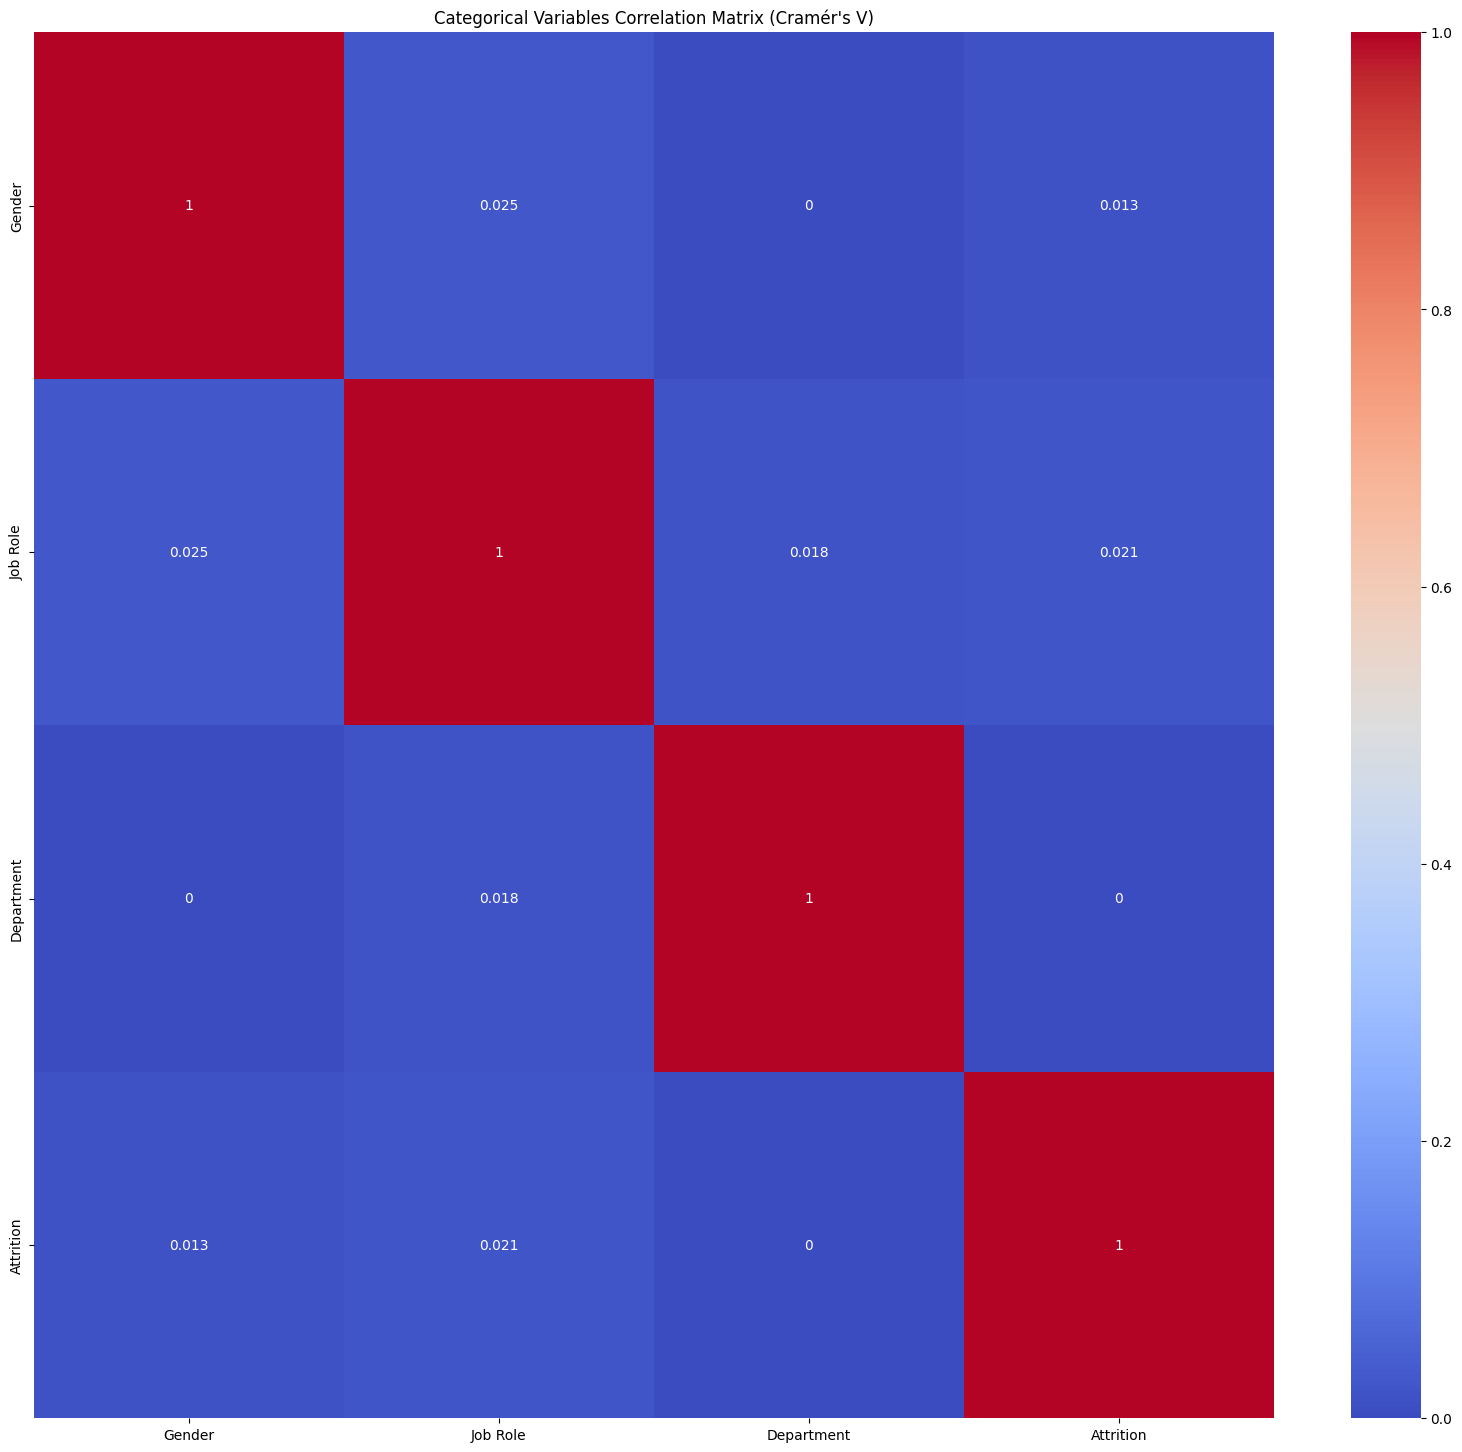

In [7]:
def cramers_v(confusion_matrix):
    """Calculate Cramér's V for the given confusion matrix."""
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()  # Get total number of observations
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1) if n > 1 else 0)
    rcorr = r - ((r-1)**2)/(n-1) if n > 1 else r
    kcorr = k - ((k-1)**2)/(n-1) if n > 1 else k
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Select the categorical variables that you want to analyze
categorical_cols = ['Gender', 'Job Role', 
         'Department', 'Attrition']
# Clean data to remove missing values
corr_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0
        else:
            confusion_matrix = pd.crosstab(df[col1], df[col2])
            corr_matrix.loc[col1, col2] = cramers_v(confusion_matrix)

# Convert the data type to floating-point
corr_matrix = corr_matrix.astype(float)

# Visual correlation matrix
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Categorical Variables Correlation Matrix (Cramér\'s V)')
plt.show()


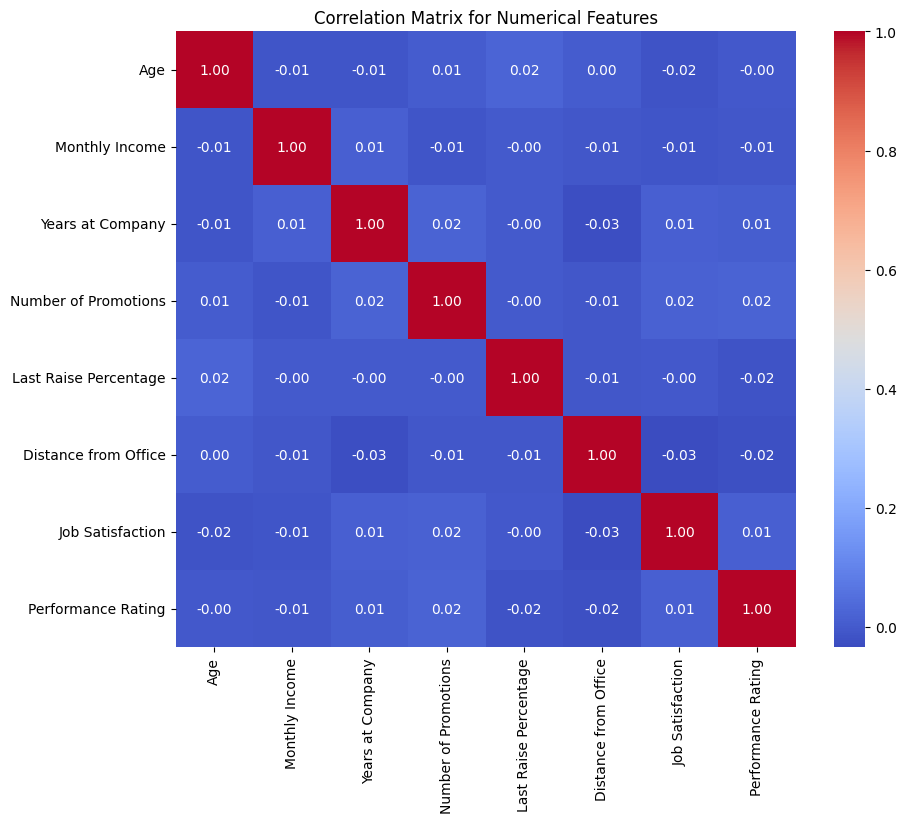

In [8]:
# Compute the correlation matrix for numerical columns only
numerical_columns = ['Age', 'Monthly Income', 'Years at Company', 'Number of Promotions', 
                     'Last Raise Percentage', 'Distance from Office', 'Job Satisfaction', 
                     'Performance Rating']

corr_matrix = df[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Numerical Features')
plt.show()

In [9]:
# Convert the 'Attrition' column: 'Yes' to 1 and 'No' to 0
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

# Display the first few rows to confirm the change
df.head()


Employee ID  Age  Gender    Job Role Department  Monthly Income  \
0            1   50    Male          HR         IT           11547   
1            2   36    Male       Sales    Support            8643   
2            3   29    Male  Technician         HR           12418   
3            4   42    Male  Technician    Support           11441   
4            5   40  Female    Engineer      Sales            9178   

   Years at Company  Number of Promotions  Last Raise Percentage  \
0                12                     1              12.288783   
1                28                     4               3.496371   
2                12                     4               4.796945   
3                25                     1              10.310471   
4                25                     2               6.210127   

   Distance from Office  Job Satisfaction  Performance Rating  Attrition  
0             41.307654                 9                   1          0  
1             44.733204                 8                   1          1  
2             18.646876                 1                   3          0  
3             15.790848                 8                   4          0  
4             41.239179                 6                   4          0

In [10]:
from scipy.stats import ttest_ind

In [12]:
# Define the numeric features and the target variable
numeric_features = ['Age', 'Monthly Income', 'Years at Company', 'Number of Promotions',
                    'Last Raise Percentage', 'Distance from Office', 'Job Satisfaction',
                    'Performance Rating']
target = 'Attrition'

# Ensure 'Attrition' is binary and convert to integer type
df[target] = df[target].astype(int)

# Perform t-tests for each numeric feature
t_test_results = {}
for feature in numeric_features:
    no_attrition = df[df[target] == 0][feature]
    yes_attrition = df[df[target] == 1][feature]
    t_stat, p_value = stats.ttest_ind(no_attrition, yes_attrition, equal_var=False)
    t_test_results[feature] = (t_stat, p_value)

# Display the results
t_test_results

{'Age': (-1.2701401346484282, 0.20419088513539313),
 'Monthly Income': (-1.766782493969072, 0.07742553541149293),
 'Years at Company': (5.779035193977856, 8.764613961216754e-09),
 'Number of Promotions': (6.550883205652668, 7.303282366636e-11),
 'Last Raise Percentage': (0.17875621452940071, 0.8581481191594507),
 'Distance from Office': (-16.72400312997231, 1.13271460215268e-58),
 'Job Satisfaction': (9.217059123901592, 7.775228418952353e-20),
 'Performance Rating': (7.518670837417109, 8.460946377762192e-14)}

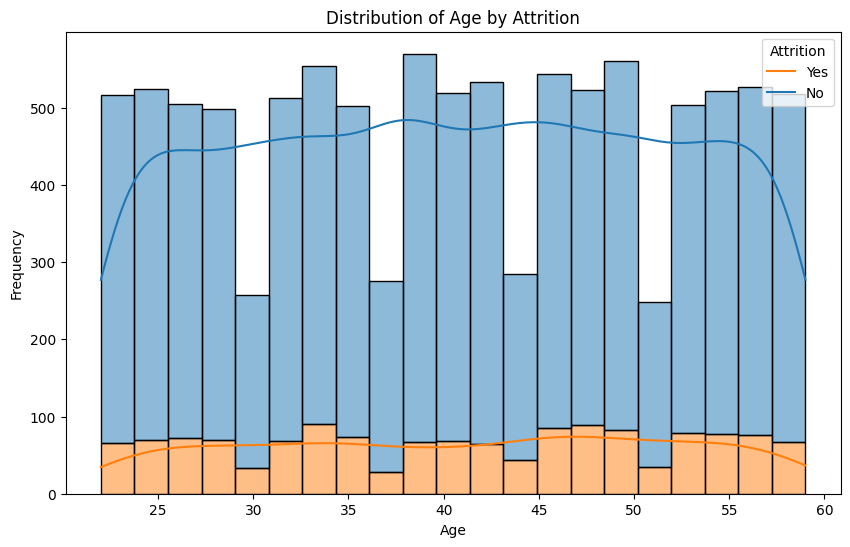

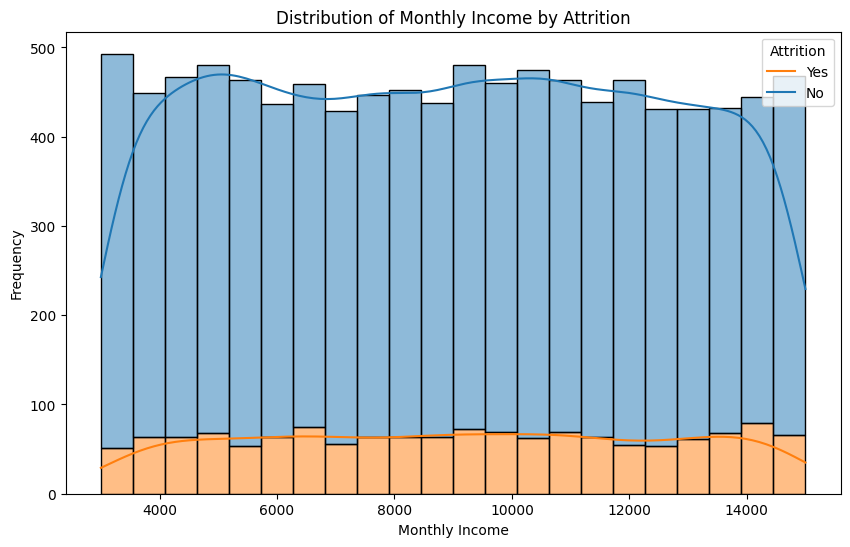

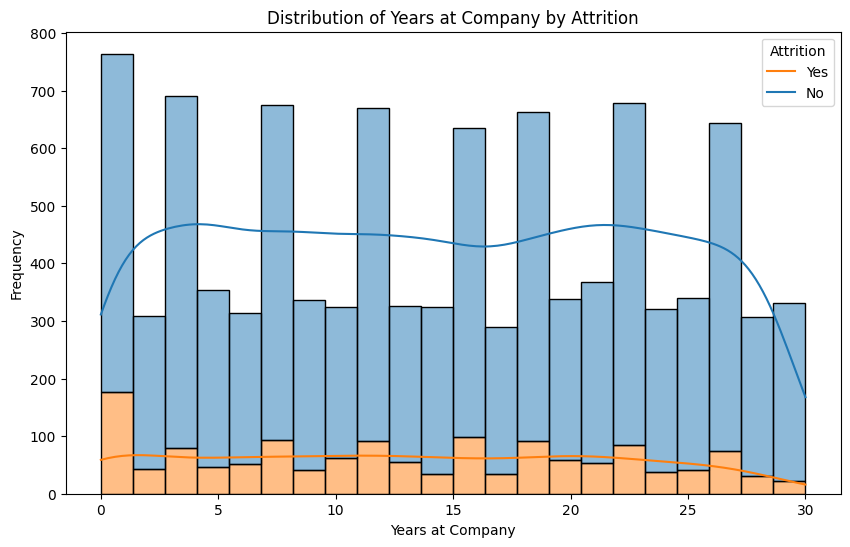

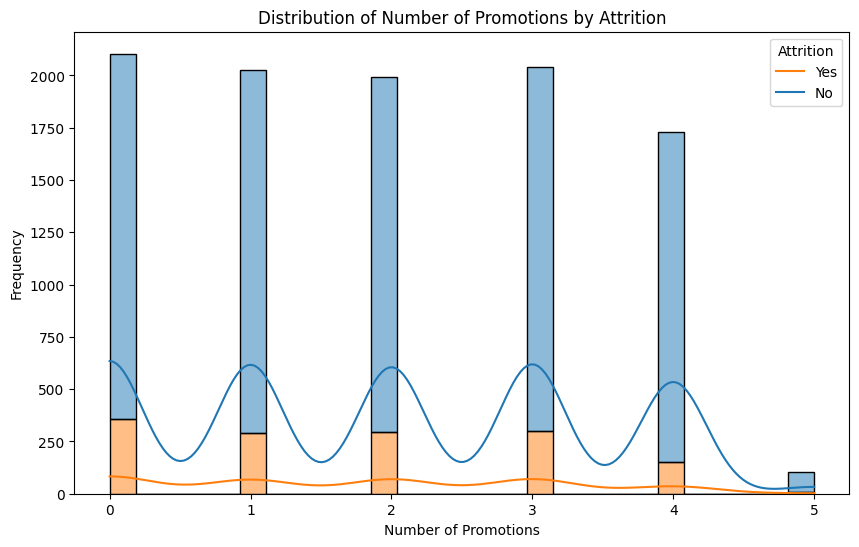

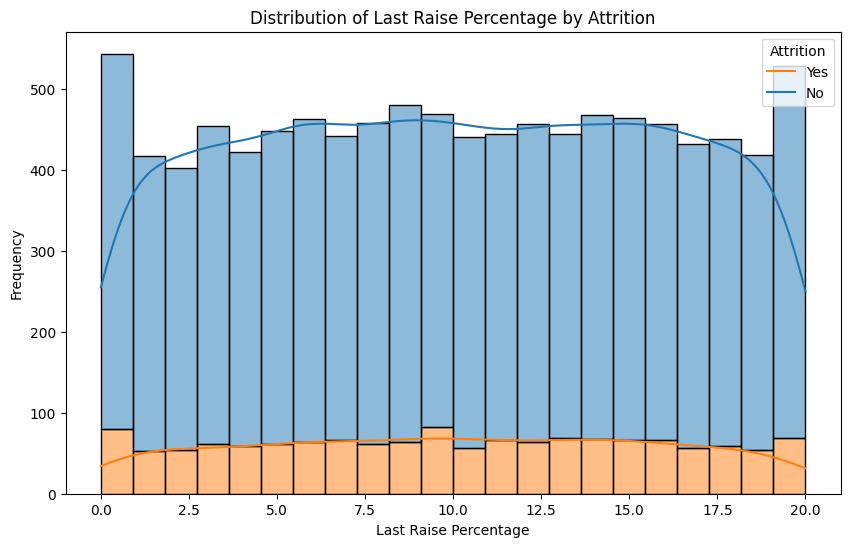

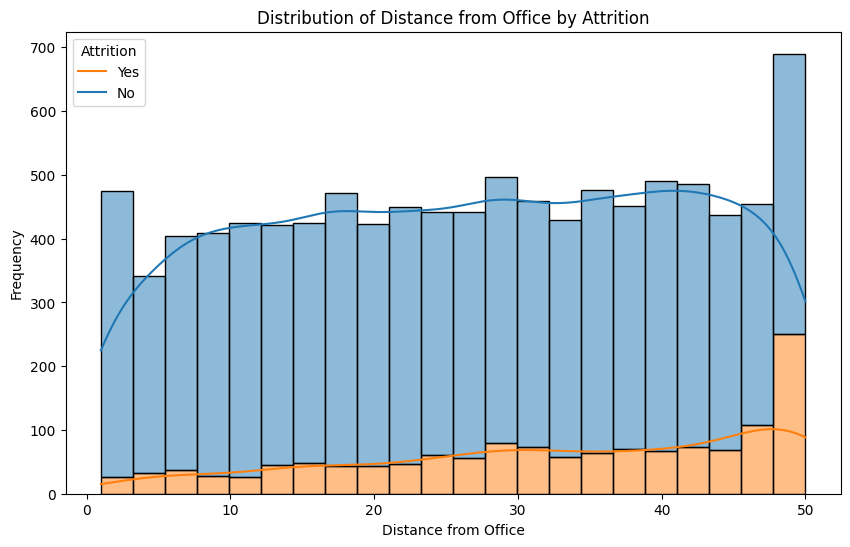

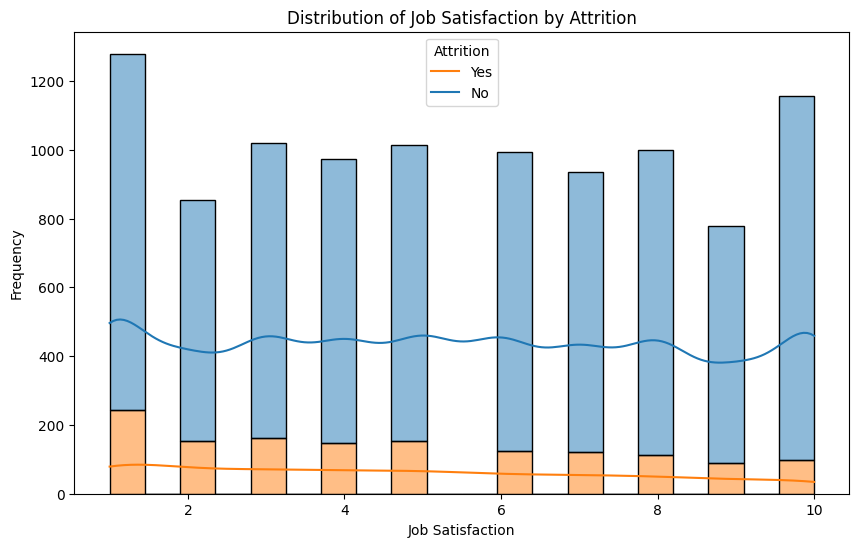

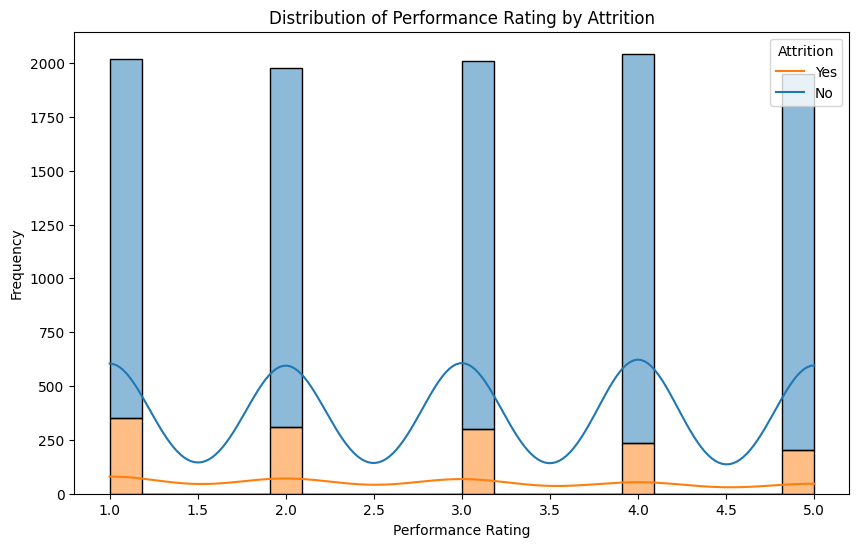

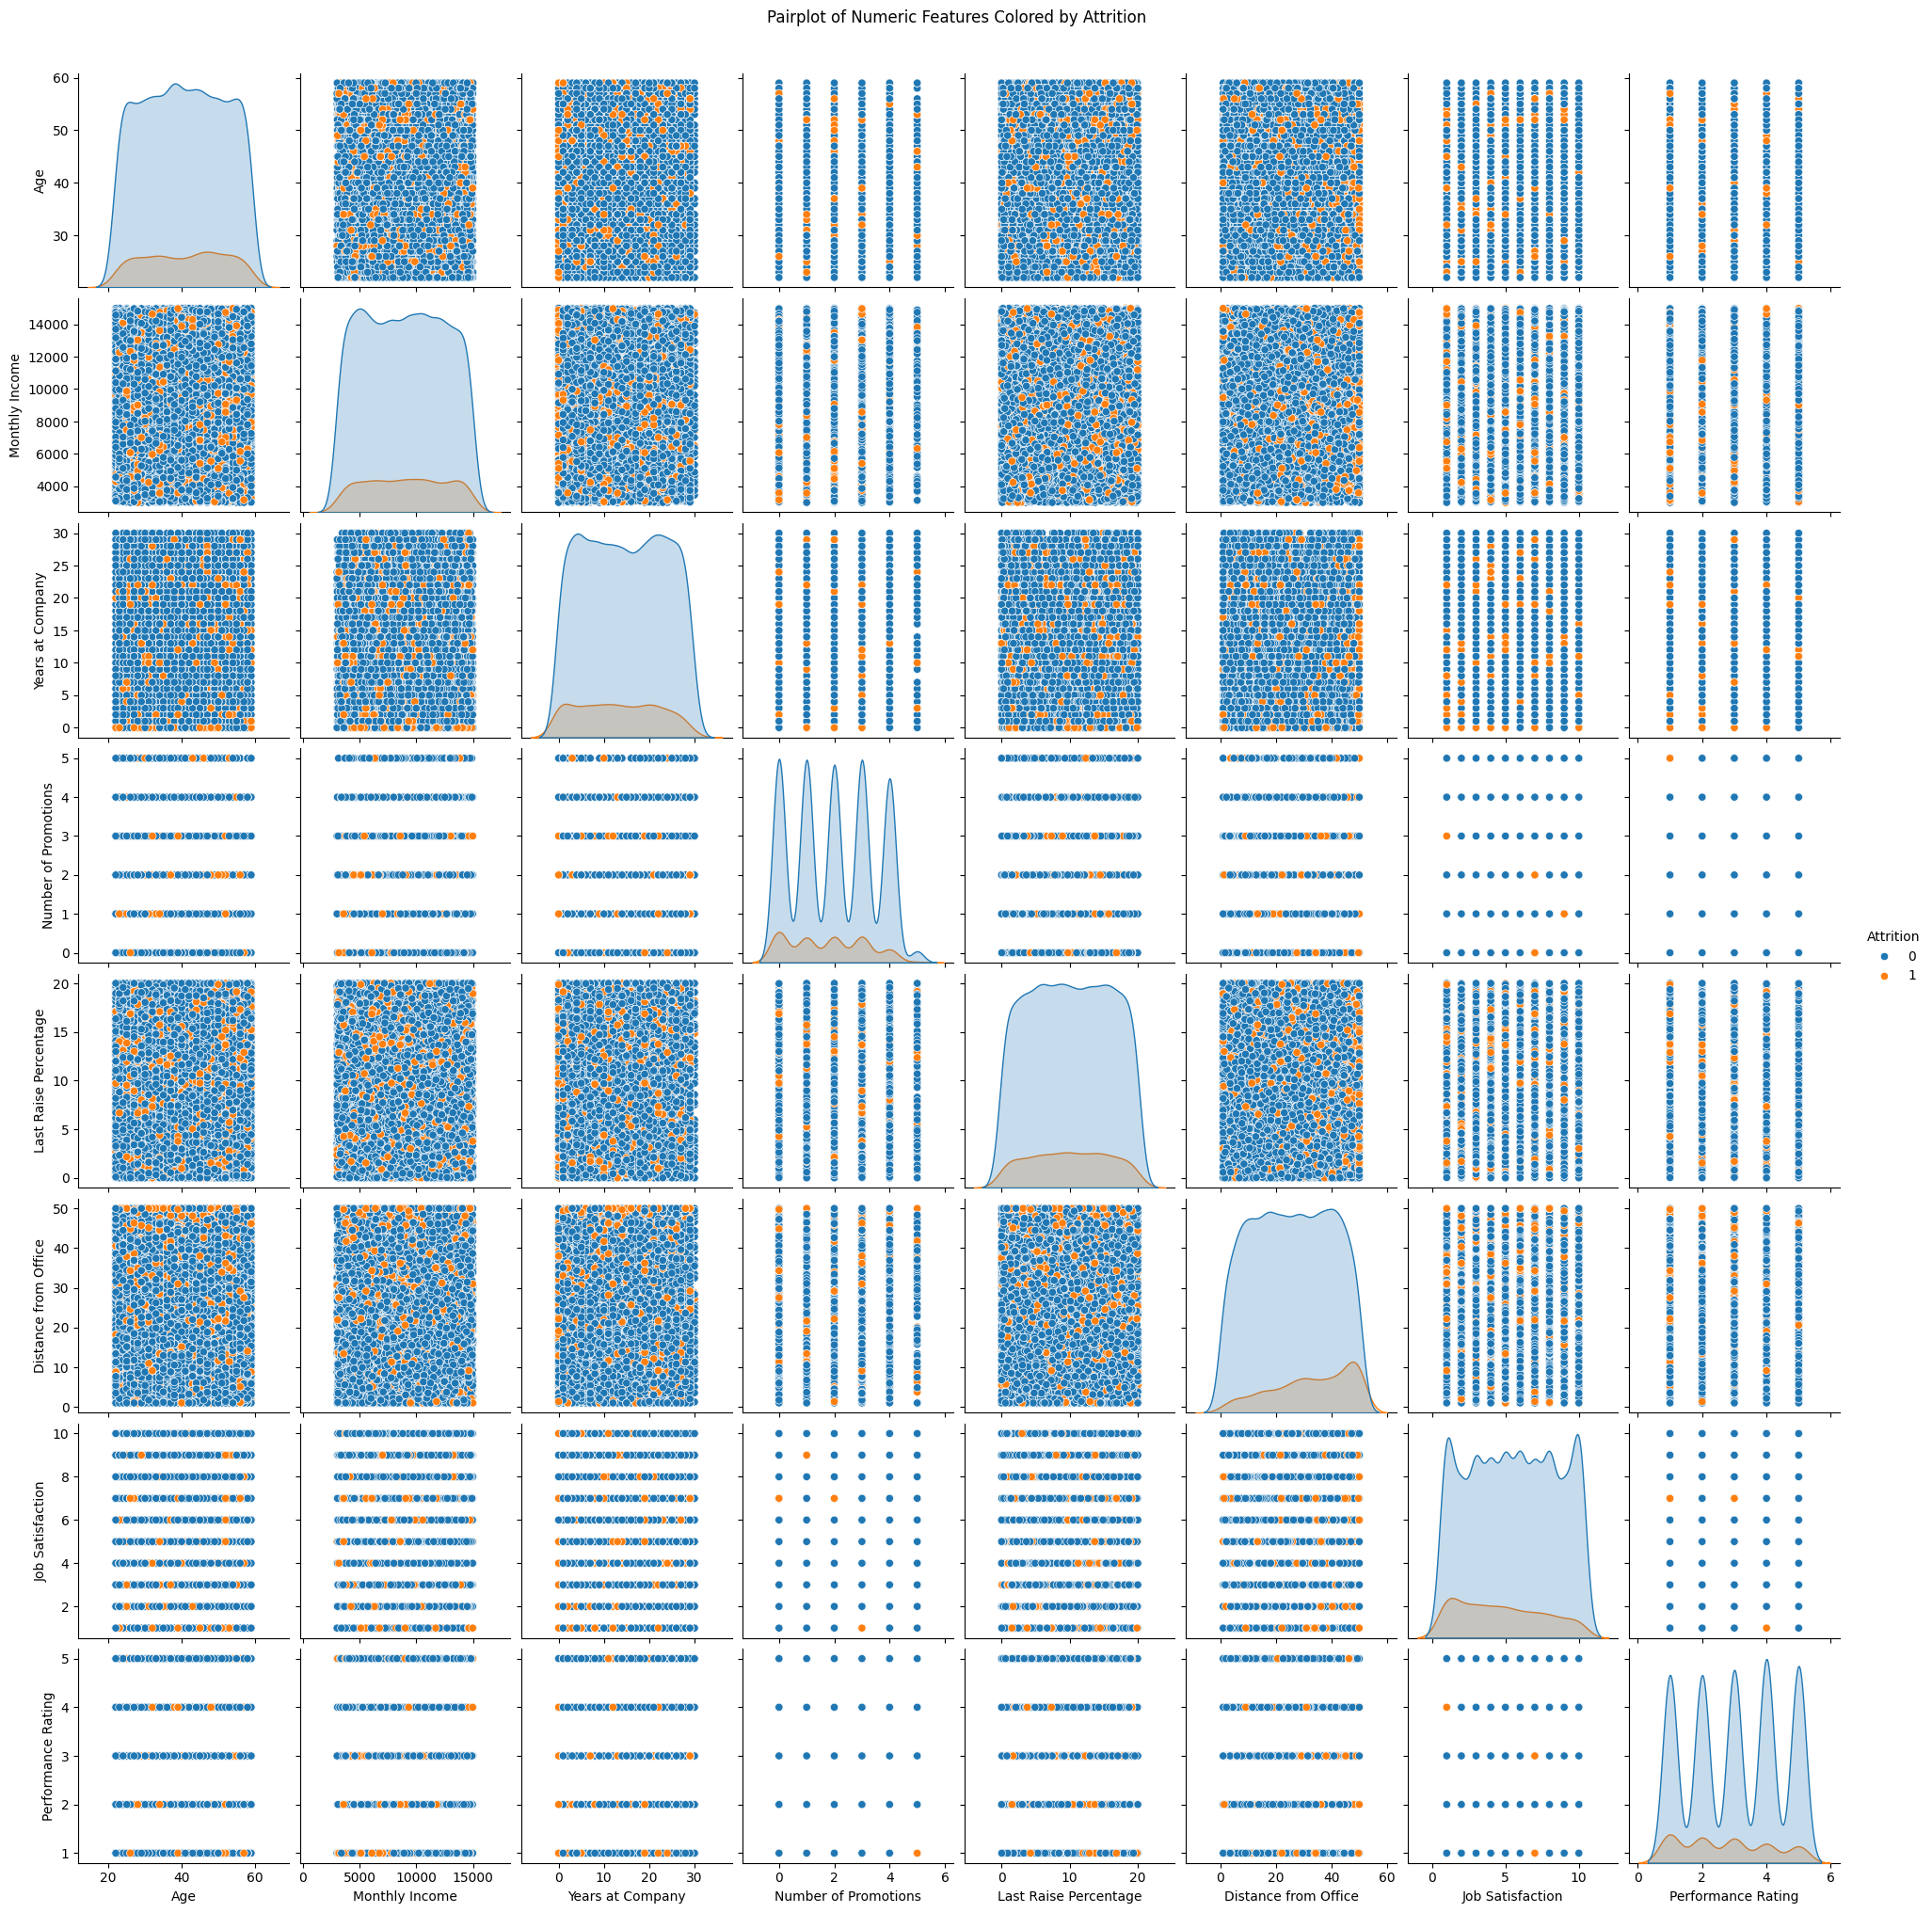

In [38]:
# Function to plot distributions
def plot_distribution(feature):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, hue=target, multiple="stack", kde=True)
    plt.title(f'Distribution of {feature} by Attrition')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend(title='Attrition', labels=['Yes', 'No'])
    plt.show()

# Plot distributions for numeric features
for feature in numeric_features:
    plot_distribution(feature)

# Pairplot to see interactions
sns.pairplot(df, hue=target, vars=numeric_features, diag_kind='kde', height=2.5)
plt.suptitle('Pairplot of Numeric Features Colored by Attrition', y=1.02)
plt.show()

In [13]:
X = df[['Monthly Income', 'Years at Company', 'Number of Promotions', 
                     'Last Raise Percentage', 'Distance from Office', 'Job Satisfaction', 
                     'Performance Rating','Job Role']]
y = df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# build our pipeline that includes these transformations
numeric_columns = ['Monthly Income', 'Years at Company', 'Number of Promotions', 
                     'Last Raise Percentage', 'Distance from Office', 'Job Satisfaction', 
                     'Performance Rating']
categorical_columns = ['Job Role']

preprocessor = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns)
    ]
)

In [14]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [15]:

# Define the models
knn = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())])
logreg = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())])
nb = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GaussianNB())])
svm = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SVC())])
dt = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier())])

# Cross validation to determine in general which model works best for the given problem
knn_scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
logreg_scores = cross_val_score(logreg, X_train, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='f1', cv=5)
svm_scores = cross_val_score(svm, X_train, y_train, scoring='f1', cv=5)
dt_scores = cross_val_score(dt, X_train, y_train, scoring='f1', cv=5)

# Print the average F1 scores for each model
print('KNN F1 Score:', np.mean(knn_scores))
print('Logistic Regression F1 Score:', np.mean(logreg_scores))
print('Naive Bayes F1 Score:', np.mean(nb_scores))
print('SVM F1 Score:', np.mean(svm_scores))
print('Decision Tree F1 Score:', np.mean(dt_scores))

KNN F1 Score: 0.09996949117454282
Logistic Regression F1 Score: 0.004081632653061224
Naive Bayes F1 Score: 0.010122249131581506
SVM F1 Score: 0.0
Decision Tree F1 Score: 0.2156701508313132


In [16]:
# Since the target is imbalanced, use f1-weighted score instead of f1 score
# Cross validation to determine in general which model works best for the given problem
knn_scores = cross_val_score(knn, X_train, y_train, scoring='f1_weighted', cv=5)
logreg_scores = cross_val_score(logreg, X_train, y_train, scoring='f1_weighted', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='f1_weighted', cv=5)
svm_scores = cross_val_score(svm, X_train, y_train, scoring='f1_weighted', cv=5)
dt_scores = cross_val_score(dt, X_train, y_train, scoring='f1_weighted', cv=5)

# Print the average weighted F1 scores for each model
print('KNN Weighted F1 Score:', np.mean(knn_scores))
print('Logistic Regression Weighted F1 Score:', np.mean(logreg_scores))
print('Naive Bayes Weighted F1 Score:', np.mean(nb_scores))
print('SVM Weighted F1 Score:', np.mean(svm_scores))
print('Decision Tree Weighted F1 Score:', np.mean(dt_scores))

KNN Weighted F1 Score: 0.8025537423647815
Logistic Regression Weighted F1 Score: 0.7977855820523836
Naive Bayes Weighted F1 Score: 0.798523403709693
SVM Weighted F1 Score: 0.7970975111536285
Decision Tree Weighted F1 Score: 0.7739446004987905


In [17]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [18]:
# Pipeline for KNeighborsClassifier
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Parameter grid for Grid Search
param_dist_knn = {
    'classifier__n_neighbors': [5, 7, 9, 15, 35, 45, 55],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Perform Randomized Search for KNN
random_search_knn = RandomizedSearchCV(knn_pipeline, param_dist_knn, n_iter=50, cv=5, scoring='f1_weighted', random_state=42)
random_search_knn.fit(X_train, y_train)

print("Best KNN parameters:", random_search_knn.best_params_)
print("Best KNN F1 score:", random_search_knn.best_score_)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 42 is smaller than n_iter=50. Running 42 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best KNN parameters: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 9, 'classifier__metric': 'manhattan'}
Best KNN F1 score: 0.8036735611329092


In [19]:
# Pipeline for DecisionTreeClassifier
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

# Parameter grid for Randomized Search for Decision Tree
param_dist_dt = {
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# Perform Randomized Search for Decision Tree
random_search_dt = RandomizedSearchCV(dt_pipeline, param_dist_dt, n_iter=50, cv=5, scoring='f1_weighted', random_state=42)
random_search_dt.fit(X_train, y_train)

print("Best Decision Tree parameters:", random_search_dt.best_params_)
print("Best Decision Tree F1 score:", random_search_dt.best_score_)


Best Decision Tree parameters: {'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 10, 'classifier__max_depth': 10, 'classifier__criterion': 'gini'}
Best Decision Tree F1 score: 0.8201138059299712


In [21]:
# Best parameters for Decision Tree
best_params_dt = random_search_dt.best_params_

# Final DecisionTreeClassifier with best parameters
final_dt_classifier = DecisionTreeClassifier(
    max_depth=best_params_dt['classifier__max_depth'],
    min_samples_split=best_params_dt['classifier__min_samples_split'],
    min_samples_leaf=best_params_dt['classifier__min_samples_leaf'],
    criterion=best_params_dt['classifier__criterion']
)

# Create the final pipeline for Decision Tree
final_dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_dt_classifier)
])

# Fit the final pipeline on the training data
final_dt_pipeline.fit(X_train, y_train)

# Predict the results on the test set
dt_pred = final_dt_pipeline.predict(X_test)

# Predict the probability of the results on the test set
dt_probs = final_dt_pipeline.predict_proba(X_test)



Decision Tree Accuracy: 0.84
Decision Tree Weighted Precision: 0.78
Decision Tree Weighted Recall: 0.84
Decision Tree Weighted F1 Score: 0.80


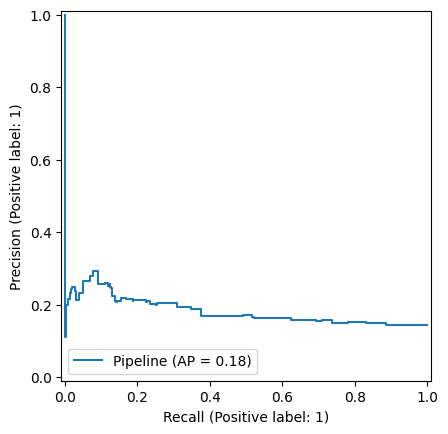

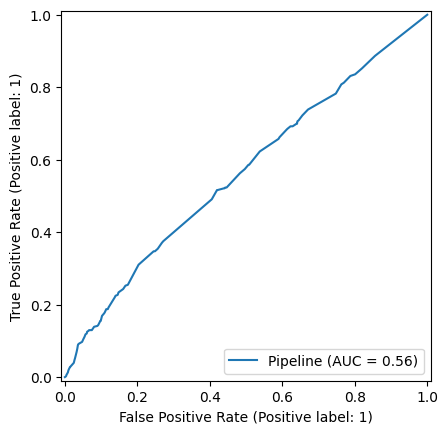

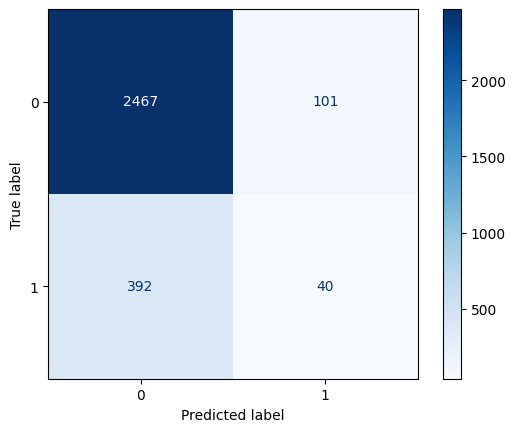

In [24]:
# Evaluation metrics
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_precision_weighted = precision_score(y_test, dt_pred, average='weighted')
dt_recall_weighted = recall_score(y_test, dt_pred, average='weighted')
dt_f1_weighted = f1_score(y_test, dt_pred, average='weighted')

print(f'Decision Tree Accuracy: {dt_accuracy:.2f}')
print(f'Decision Tree Weighted Precision: {dt_precision_weighted:.2f}')
print(f'Decision Tree Weighted Recall: {dt_recall_weighted:.2f}')
print(f'Decision Tree Weighted F1 Score: {dt_f1_weighted:.2f}')

# Display precision-recall curve for Decision Tree
PrecisionRecallDisplay.from_estimator(final_dt_pipeline, X_test, y_test)
plt.show()

# Display ROC curve for Decision Tree
RocCurveDisplay.from_estimator(final_dt_pipeline, X_test, y_test)
plt.show()

# Display confusion matrix
cm = confusion_matrix(y_test, dt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [46]:
#Best KNN parameters: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 9, 'classifier__metric': 'manhattan'}
best_params = random_search_knn.best_params_

# Final KNeighborsClassifier with best parameters
final_classifier = KNeighborsClassifier(
    n_neighbors=best_params['classifier__n_neighbors'],
    metric=best_params['classifier__metric'],
    weights=best_params['classifier__weights']
)

# Create the final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_classifier)
])

# Fit the final pipeline on the training data
final_pipeline.fit(X_train, y_train)

# Predict the results on the test set
pred = final_pipeline.predict(X_test)

# Predict the probability of the results on the test set
probs = final_pipeline.predict_proba(X_test)

# Display the results
print("Predictions:", pred)
print("Prediction Probabilities:", probs)

Predictions: [0 0 0 ... 0 0 0]
Prediction Probabilities: [[0.88888889 0.11111111]
 [0.77777778 0.22222222]
 [0.88888889 0.11111111]
 ...
 [0.77777778 0.22222222]
 [0.88888889 0.11111111]
 [0.77777778 0.22222222]]


In [47]:
# Calculate the weighted scores
f1 = f1_score(y_test, pred, average='weighted')
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='weighted')
recall = recall_score(y_test, pred, average='weighted')

# Display the results
print("Weighted F1 Score:", f1)
print("Accuracy Score:", accuracy)
print("Weighted Precision Score:", precision)
print("Weighted Recall Score:", recall)

Weighted F1 Score: 0.794094914428511
Accuracy Score: 0.853
Weighted Precision Score: 0.7840691744333154
Weighted Recall Score: 0.853


In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression

Text(0.5, 23.52222222222222, 'Predicted Classes')

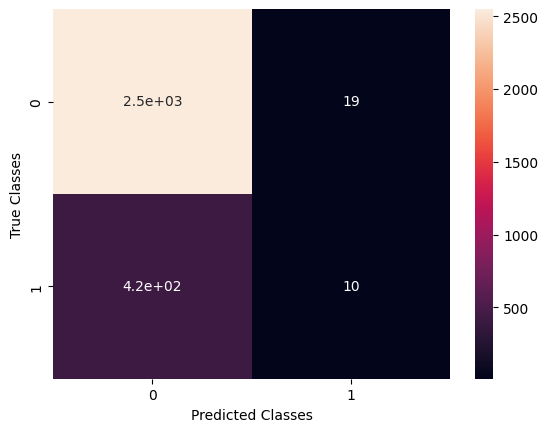

In [22]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True)
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')

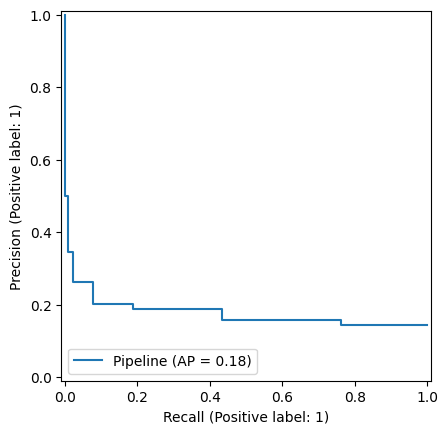

In [23]:
# Precision Recall Curve
display = PrecisionRecallDisplay.from_estimator(final_pipeline, X_test, y_test)

In [24]:
# adjust to 30% threshold
new_predictions =[]
for i in probs[:,1]:
    if i >= 0.3:
        new_predictions.append(1)
    else:
        new_predictions.append(0)

Text(0.5, 23.52222222222222, 'New Predicted Classes')

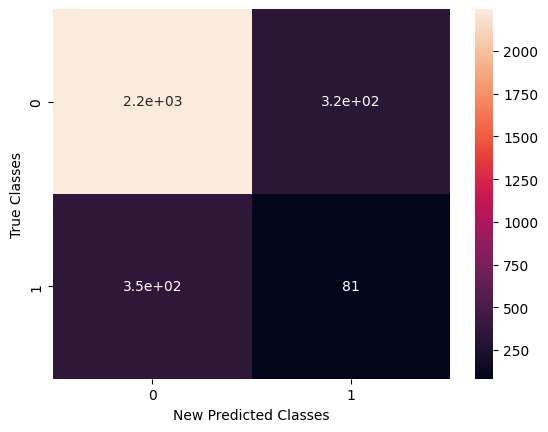

In [25]:
sns.heatmap(confusion_matrix(y_test, new_predictions), annot=True)
plt.ylabel('True Classes')
plt.xlabel('New Predicted Classes')

In [26]:
new_f1 = f1_score(y_test, new_predictions, average='weighted')
new_accuracy = accuracy_score(y_test,new_predictions)
new_precision = precision_score(y_test,new_predictions, average='weighted')
new_recall = recall_score(y_test,new_predictions, average='weighted')

# Display the results
print("Weighted F1 Score:", new_f1)
print("Accuracy Score:", new_accuracy)
print("Weighted Precision Score:", new_precision)
print("Weighted Recall Score:", new_recall)

Weighted F1 Score: 0.19401197604790418
Accuracy Score: 0.7756666666666666
Weighted Precision Score: 0.20099255583126552
Weighted Recall Score: 0.1875
